In [66]:
import os
import random
import time
from dataclasses import dataclass
import uuid

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

import gym
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import wandb
import argparse
import yaml
import pickle
from policy_finetune.scripts.actor_utils import FeatureExtractor
from policy_finetune.scripts.sac_rlpd import Actor, SoftQNetwork
from policy_finetune.scripts.utils import get_radar_heat_map, center_state, visualiza_radar_config
from tensordict import MemoryMappedTensor, TensorDict
from gym_env.env.radar_env import RadarEnv, MapConfig
from evasion_guidance.scripts.evasion_risk import EvasionRisk
%matplotlib widget

In [67]:
checkpoints_path = "/home/yixuany/workspace/CORL/output"
run_name = "SAC_rlpd-d5d82e6b"
iter_num = 700_000
model_dict = torch.load(os.path.join(checkpoints_path, run_name, f"actor_checkpoint_{iter_num}.pt"))
q_model_dict = torch.load(os.path.join(checkpoints_path, run_name, f"q1_checkpoint_{iter_num}.pt"))

In [68]:
with open(os.path.join(checkpoints_path, run_name, "config.yaml"),"r") as file_object:
    config = yaml.load(file_object,Loader=yaml.SafeLoader)

In [69]:
# Set environment parameters.
img_size = config['env']['img_size']
time_max = config['env']['max_time_step']
observation_img_size = [1, img_size, img_size]
action_min = -1.0
action_max = 1.0
action_dim = config['env']['action_dim']
action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(action_dim,))
map_size = config['env']['map_size']
observation_space= gym.spaces.Dict({"heat_map": gym.spaces.Box(0, 255, observation_img_size), 
                    "goal_direction": gym.spaces.Box(-1, 1, shape=(2,)),
                    "current_loc": gym.spaces.Box(0, 1, shape=(2,)),
                    "time_spent": gym.spaces.Box(-1, 1, shape=(2,)),
                    "risk_measure": gym.spaces.Box(-1, 1, shape=(2,))})

In [70]:
model_dict

OrderedDict([('action_scale', tensor(1., device='cuda:0')),
             ('action_bias', tensor(0., device='cuda:0')),
             ('feature_extractor.extractors.heat_map.cnn.0.weight',
              tensor([[[[-3.0368e-02,  6.8341e-02,  8.0951e-02,  ..., -1.2542e-01,
                         -1.7003e-01, -1.7226e-01],
                        [-3.4886e-02,  5.9585e-02, -3.1289e-02,  ...,  6.6831e-02,
                          3.1378e-02,  5.6194e-02],
                        [ 6.0025e-02, -1.0026e-02,  4.0673e-02,  ..., -1.7527e-01,
                         -1.6430e-01, -8.6336e-02],
                        ...,
                        [-1.3984e-01,  6.2953e-02,  3.4789e-02,  ..., -1.7495e-01,
                         -4.3689e-02, -1.8004e-01],
                        [-3.8865e-02, -2.0166e-02,  2.9954e-02,  ...,  7.8248e-03,
                          5.1731e-02, -1.3678e-01],
                        [-1.0310e-01, -3.6066e-02,  1.7313e-02,  ..., -3.1741e-03,
                         -

In [71]:
actor = Actor(observation_space, action_dim, action_max, action_min)
actor.load_state_dict(model_dict)
actor.eval()

Actor(
  (feature_extractor): FeatureExtractor(
    (extractors): ModuleDict(
      (current_loc): Flatten(start_dim=1, end_dim=-1)
      (goal_direction): Flatten(start_dim=1, end_dim=-1)
      (heat_map): NatureCNN(
        (cnn): Sequential(
          (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
          (1): ReLU()
          (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
          (6): Flatten(start_dim=1, end_dim=-1)
        )
        (linear): Sequential(
          (0): Linear(in_features=5184, out_features=256, bias=True)
          (1): ReLU()
        )
      )
      (risk_measure): Flatten(start_dim=1, end_dim=-1)
      (time_spent): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (fc1): Linear(in_features=264, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc_mean): Linear(in_features=64, out_features=1, bias=Tr

In [72]:
q_network = SoftQNetwork(observation_space, action_dim)
q_network.load_state_dict(q_model_dict)
q_network.eval()

SoftQNetwork(
  (feature_extractor): FeatureExtractor(
    (extractors): ModuleDict(
      (current_loc): Flatten(start_dim=1, end_dim=-1)
      (goal_direction): Flatten(start_dim=1, end_dim=-1)
      (heat_map): NatureCNN(
        (cnn): Sequential(
          (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
          (1): ReLU()
          (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
          (6): Flatten(start_dim=1, end_dim=-1)
        )
        (linear): Sequential(
          (0): Linear(in_features=5184, out_features=256, bias=True)
          (1): ReLU()
        )
      )
      (risk_measure): Flatten(start_dim=1, end_dim=-1)
      (time_spent): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (fc1): Linear(in_features=265, out_features=256, bias=True)
  (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=256, out_features=

In [73]:
delta_t = config['env']['delta_t']
V = config['env']['V']
radar_radius = config['env']['radar_radius']
aircraft_detection_range = config['env']['aircraft_detection_range']
grid_size=2*aircraft_detection_range/img_size
time_scaling = config['env']['observation']['time_scaling']
action_rescaling = config['env']['action_max']
max_time_steps = config['env']['max_time_step']

In [74]:
data_config_path = "/home/yixuany/workspace/evasion_nonlinear_guidance/evasion_guidance/data/config.yml"
with open(data_config_path,"r") as file_object:
    data_config = yaml.load(file_object,Loader=yaml.SafeLoader)

In [92]:
episode_idx = 20
data_path = "/home/yixuany/workspace/CORL/data/"
episode_dict = np.load(data_path + f'episode_{episode_idx}.npy',allow_pickle='TRUE').item()

state_cur = episode_dict['start_state']
radar_locs = episode_dict['radar_locations']
radar_orientations = episode_dict['radar_orientations']
goal_location = episode_dict['goal_location']
# goal_location = [0.0, 0.0]

risk_evaluator = EvasionRisk(radar_locs, 0, 100)
risk_interval = data_config['planner']['risk_buffer_length']
risk_buffer = np.zeros(risk_interval)

time_spent = 0
time_spent_heat_map = 0
total_risk = 0
trajectory = [state_cur]
q_values = []
start = time.time()
with torch.no_grad():
    while np.linalg.norm(state_cur[:2] - goal_location) > config['env']['goal_tolerance']:
        # if time_spent % 10 == 0:
        #     print("Time spent: ", time_spent)
        if time_spent > 8:
            print("Reached time limit.")
            break
        hm_start = time.time()
        
        heat_map = get_radar_heat_map(state_cur, radar_locs, img_size,
                                           aircraft_detection_range,
                                           grid_size)
        hm_end = time.time()
        time_spent_heat_map += hm_end - hm_start
        goal_direction = center_state(state_cur, goal_location) / (map_size / 2.0)
        
        risk_max = np.max(risk_buffer)
        risk_mean = np.mean(risk_buffer)
        risk_measure = np.asarray([risk_mean, risk_max])

        obs = TensorDict({
            'heat_map': torch.from_numpy(heat_map).unsqueeze(dim=0).float(),
            'goal_direction': torch.from_numpy(goal_direction).unsqueeze(dim=0).float(),
            "current_loc": torch.from_numpy(state_cur[:2] / map_size).unsqueeze(dim=0).float(),
            "time_spent": torch.from_numpy(np.array([np.cos(time_spent / max_time_steps), np.sin(time_spent / max_time_steps)])).unsqueeze(dim=0).float(),
            'risk_measure': torch.from_numpy(risk_measure).unsqueeze(dim=0).float()
        })

        pi, log_pi, mean = actor.get_action(obs)
        u = pi.squeeze().cpu().detach().numpy()
        # print("Control: ", u)
        u = action_rescaling*u
        q_values.append(q_network(obs, mean).squeeze().cpu())
        p_risk = risk_evaluator.evalute_risk(state_cur, u)
        risk_buffer[time_spent % risk_interval] = p_risk
        total_risk += p_risk
        state_cur = state_cur + delta_t*np.array([V*np.cos(state_cur[2]), V*np.sin(state_cur[2]), u/V])
        time_spent += 1
        # print(state_cur)
        trajectory.append(state_cur)
end = time.time()
# print("Total time steps: ", time_spent)
print("Total Time: ", end - start)
# print("Time spent on heat map", time_spent_heat_map)
print("Length of trajectory: ", len(trajectory))
print("Total Risk: ", total_risk)
trajectory = np.asarray(trajectory)
q_values = np.asarray(q_values)

Reached time limit.
Total Time:  0.06069016456604004
Length of trajectory:  10
Total Risk:  6.910774615983079


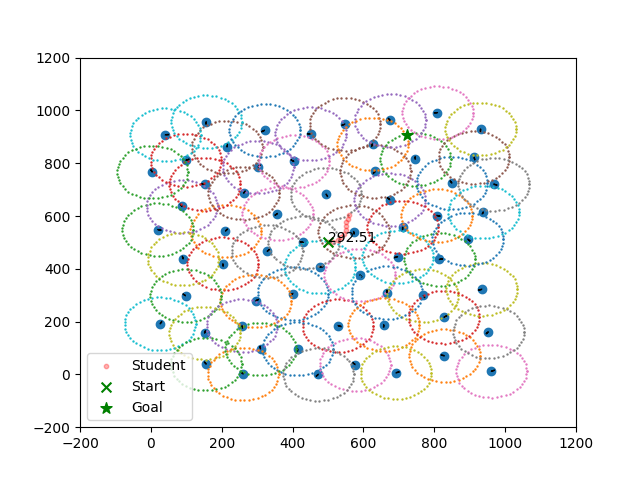

In [93]:
plt.close()
fig, ax = plt.subplots()
visualiza_radar_config(radar_locs, radar_orientations, radius=radar_radius, xlim=[0, map_size], ylim=[0, map_size])
ax.scatter(trajectory[:, 0], trajectory[:, 1], s=10, c='r', alpha=0.3, label='Student')
# ax.scatter(episode_dict['state_history'][:, 0], episode_dict['state_history'][:, 1], s=10, c='g', alpha=0.3, label='Expert')
ax.scatter(episode_dict['start_state'][0], episode_dict['start_state'][1], s=50, c='g', marker='x', label="Start")
ax.scatter(goal_location[0], goal_location[1], s=70, c='g', marker='*', label='Goal')

for i, q_val in enumerate(q_values):
    if i % 10 == 0:
    # if q_val < 0:
        ax.annotate(int(100*q_val)/100, (trajectory[i, 0], trajectory[i, 1]))

ax.set_xlim(-200, 1.2*map_size)
ax.set_ylim(-200, 1.2*map_size)
ax.legend()